# Ising model

This code simulates the 2d Ising model using Monte Carlo methods. This is a simple physical problem where we take a square lattice of points with a magnet at each point. These magnets can either point up or down and the interactions are such that neighboring magnets like to be aligned. This would all be very simple if the system were not at finite temperature. The magnets would flip to end up all aligned. However the energy coming from the finite temperature may randomly cause some magnets to flip and perturb the system, which can prevent it from reaching a uniform state. If the temperature is low enough the magnets gradually form bigger and bigger islands where they are aligned and if we wait long enough they all become aligned. If the temperature if high enough the system never uniformizes because there is a balance between wanted flips and unwanted thermal flips. The transition between those two possible outcomes happens at a known temperature of 2.269 degrees (in the units that we use). The goal of the project is to give a picture of the state to a neural network and it can tell us if we are above or below the critical temperature.

The algorithm that is used to simulate the 2d Ising is called Metropolis. The steps go as follows:
1. Initialize the lattice randomly with 1 or -1 at each site. 1 is for when the magnet points up and -1 if for when it points down.
2. Randomly select a point on the grid. 
3. Calculate the change in the energy that would occur if we flipped the magnet. The energy is given by $E=-\sum_{i,j}s_i s_j$, where we sum over all pairs of points on the lattice and $s_i$ is $\pm 1$. If the change is negative, the system likes the change so the magnet is indeed flipped. If the change is positive, there is still a probability of $e^{-\frac{\Delta E}{T}}$ that the magnet gets flipped because of thermal fluctuations. Here $T$ is the temperature and $\Delta E$ is the change in energy that occurs when we flip the magnet.
4. Repeat step 3 for a number of steps equal to the size of a side of the lattice. This is considered as one time step. (This is where we update the value for the magnetization and the energy if interested in these quantites.)
5. Repeat steps 3 and 4 for a given number of time steps.
6. Plot, print the result.


After the simulation, we use the results to train a neural network that determines if the state of the Ising system corresponds to a temperature higher or lower than the critical temperature.

# Simulation of the Ising model

We first import the usual libraries in order to do the simulation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math as m
import random

%matplotlib inline

The first function to create makes a square grid (simply a matrix) of a fixed size with random values at each element taken from -1 or 1. 

In [2]:
def initialize_grid(dim):
    '''
    Create a dim by dim array of numbers chosen randomly from -1 or 1.
    '''
    grid = np.random.choice([-1,1], size = (dim,dim))
    
    return grid

Next we make a function to plot a generic grid and add the option of putting a title. We need to create a color map where -1 is black and 1 is white. This will be useful to visualize results.

In [3]:
def plot_grid(grid, title=None):
    '''
    Plot grid with -1 being black and 1 being white with an option to add a title.
    '''
    # Create discrete colormap
    cmap = colors.ListedColormap(['black', 'white'])
    bounds = [-2,0,2]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    # Make plot
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap = cmap, norm=norm)
    ax.set_title(title)

This is a function that computes the magnetization of a grid. This is simply the sum of all the elements and it is useful to classify the phase of the model.

In [4]:
def compute_magnetization(grid):
    return np.sum(grid)

This is one of the main functions of the algorithm. You give it a grid and two numbers that determine a position on the grid. The function first determines where the neighboring elements are. This is important because the grid has to be periodic so border elements are special. The change in energy due to reversing this element is then computed by adding all the contributions from the neighbors. Each one contributes by $$\Delta E=2*grid(i, j)*grid(i_{neighbor}, j_{neighbor})$$

In [5]:
def energy_change(grid, i, j):
    '''
    Assums a flip of the spin at position (i,j) on the grid and computes the change of
    energy due to it.
    Returns the change in energy.
    '''
    n = grid.shape[0]
    if (i==0):
        left = n-1
    else:
        left = i-1
    if (i==n-1):
        right = 0
    else:
        right = i+1
    if (j==0):
        down = n-1
    else:
        down = j-1
    if (j==n-1):
        up = 0
    else:
        up = j+1
    dE = 2 * grid[i,j] * (grid[left,j] + grid[right,j] + grid[i,up] + grid[i,down])
    return dE

This function picks a random element of the grid. The actual output is the indices of the element.

In [6]:
def random_spin(grid):
    '''
    Choose randomly the position of one entry in the array grid.
    Returns the location of the spin.
    '''
    n = grid.shape[0]
    x_index = random.randint(0, n-1)
    y_index = random.randint(0, n-1)
    return (x_index, y_index)

This is the second important function of the algorithm. It first uses the previously defined function to pick a random point on the grid. It then starts by computing the change in energy due to reversing this element by using the previously defined function. If the change is negative the element is indeed flipped. If not there is a probability $e^{-\Delta E/T}$ that the flip still happens. The output is the grid with (potentially) some random element reversed.

In [7]:
def spin_flip(grid, T):
    '''
    Picks randomly one spin on the grid and calculates the change in energy due to flipping the spin.
    If change is negative, flip the spin.
    If change is positive, flip it only with some probability.
    Returns the new grid with the spin potentially flipped.
    '''
    i, j = random_spin(grid)
    delta_E = energy_change(grid, i, j)
    if delta_E < 0:
        grid[i,j] = -grid[i,j]
    elif random.random() < m.exp(-delta_E/T):
        grid[i,j] = -grid[i,j]
    return grid

This is the main function of the simulation where we put everything together to run the algorithm. We start by initialize a random grid. We then run the random flip n times for one time step and then repeat the process for a determined number of time steps. The final grid is returned along with (potentially) the initial and final configurations.

In [8]:
def ising_simulation(n, T, steps=100, plot=False):
    '''
    Simulate 2d Ising model.
    Inputs:
    - n: size of the square lattice is n by n
    - T: temperature
    - steps: number of flips the algorithm tries to make
    - plot: decide if the grid is plotted at the beginning and the end of the simulation
    Returns:
    - the final grid
    - if plot is True, the initial and final grids in two plots
    '''
    grid = initialize_grid(n)
    
    if plot==True:
        plot_grid(grid, title='Initial grid')
        
    for i in range(steps):
        for i in range(n):
            grid = spin_flip(grid, T)
            
    if plot==True:
        plot_grid(grid, title='Final grid')
        
    return grid

array([[ 1,  1,  1, ..., -1, -1,  1],
       [ 1, -1,  1, ..., -1, -1,  1],
       [-1,  1,  1, ..., -1,  1,  1],
       ...,
       [-1,  1, -1, ..., -1, -1, -1],
       [-1,  1,  1, ...,  1, -1, -1],
       [ 1,  1,  1, ..., -1, -1, -1]])

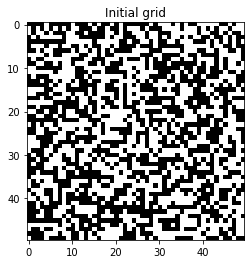

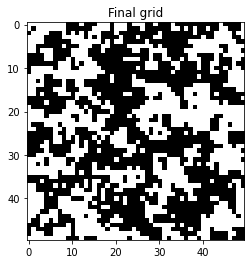

In [9]:
ising_simulation(50, 3, 3000, plot=True)

# Generating data

The code that we have so far simulates the Ising model and gives a grid back but we want to automate the production of data. The simulation is ran for different values of temperature evenly spread in a determined interval and for a fixed number of repetitions. The function records the final grids as a list of matrices and it also reshapes these grid into vectors and stacks them together to get the right form necessary for machine learning algorithms. The final step is to record in a vector if the temperature is above or below the critical one. The function prints the iteration as it runs to let us see what is going on.

In [10]:
def generate_data(size, num_temp, temp_min=0.1, temp_max=5, repeat=1, max_iter=None):
    '''
    Generate data from simulating the Ising model at different temperatures.
    The temperatures are spread equally between temp_min and temp_max.
    
    Input:
    - size: the grid is size x size
    - num_temp: number of different temperatures to consider
    - temp_min: minimum temperature to take
    - temp_max: maximum temperature
    - repeat: repeat the calculation for each temperature this number of times
    - max_iter: number of time steps in the simulation of the Ising model (default is size^2)
    
    Output:
    - raw_X: list of the arrays obtained from simulating the Ising (there are num_temp*repeat elements)
    - X: (num_temp, size^2) array where each line is a vectorized version of the grid and every line is a different run
    - y: (num_temp, 1) array that says if the simulation is made above the critical temps (y=1) or below (y=0)
    '''
    
    if max_iter==None:
        max_iter = size**2

    raw_X = []
    X = np.zeros((num_temp*repeat, size**2))
    y = np.zeros((num_temp*repeat, 1))
    temps = np.linspace(temp_min, temp_max, num = num_temp)

    for i in range(repeat):
        for j in range(num_temp):
            grid = ising_simulation(size, temps[j], max_iter)
            raw_X.append(grid)
            X[i*num_temp+j,:] = grid.reshape(1,grid.size)
            y[i*num_temp+j,:] = (temps[j] > 2.269)
            print(i*num_temp+j, end="\r")
    
    return raw_X, X, y

This generates data to use later to train the neural network for a grid of 25 by 25.

In [11]:
raw_X, X, y = generate_data(size=25, num_temp=40, repeat=20)

This uses the same grid and generates less data to use as a dev/test set.

In [12]:
raw_X_test, X_test, y_test = generate_data(size=25, num_temp=20, repeat=10)

array([1.])

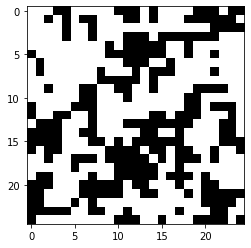

In [13]:
i = 70
plot_grid(raw_X[i])
y[i]

# Using keras

Now we want to train a neural network using keras to predict the labels y from the data X. We first import the necessary libraries and functions.

In [14]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.regularizers import l2

The first way of doing the training is simply to do it directly. We consider a network with two hidden layers (plus the input and output layers). Since there is a lot of randomness in the training (we don't train long enough to get rid of that) it is better to run the taining many times, keep track of the errors each time and average them at the end. This run uses the optimal hyperparameters found using tuning.

In [15]:
# Initialize list of training and test errors
train_errors = []
test_errors = []


# Loop to run model many times and average over results

for i in range(15):

    # Print iteration to make sure everything works
    print(i, end="\r")
    
    # Initialize model
    model = Sequential()

    # Add hidden layer with 32 units and rlu activation. Add output layer with sigmoid activation.
    model.add(Dense(25, activation='relu', kernel_regularizer=l2(0.1), input_dim=25**2))
    model.add(Dense(15, activation='relu', kernel_regularizer=l2(0.1)))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Fit model
    model.fit(X, y, epochs=40, verbose=0)

    # Add training and test errors to lists
    train_errors.append(model.evaluate(X,y,verbose=0)[1])
    test_errors.append(model.evaluate(X_test,y_test,verbose=0)[1])
    
# Average errors
avg_train_error = np.mean(train_errors)
std_train_error = np.std(train_errors)
avg_test_error = np.mean(test_errors)
std_test_error = np.std(test_errors)

print('Average of training errors: '+str(avg_train_error))
print('Standard deviation of training errors: '+str(std_train_error))
print('Average of test errors: '+str(avg_test_error))
print('Standard deviation of test errors: '+str(std_test_error))

Average of training errors: 0.9983333230018616
Standard deviation of training errors: 0.0010865326980992183
Average of test errors: 0.9190000057220459
Standard deviation of test errors: 0.012274641839515309


For a single trained model this is a way of seeing which test example was classified incorrectly.

In [16]:
(model.predict(X_test)>0.5)==y_test

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [

array([0.])

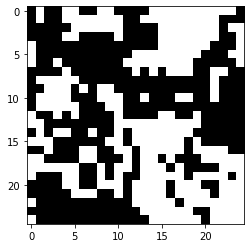

In [17]:
plot_grid(raw_X_test[13])
y[13]

# Tuning hyperparameters

Training the model is not enough. there are a lot of parameters to vary and doing it by hand is cumbersome so we can automate it a little bit. This function takes in various parameters in the training along with the data and it trains the neural network. It outputs the parameters used and the test accuracy to we can use it in a loop to find the best hyperparameters.

In [18]:
def deep_nn(X, y, X_test, y_test, layer1=10, layer2=10, lambd=0.05, num_epochs=50):

    # Initialize list of training and test errors
    train_errors = []
    test_errors = []


    # Loop to run model many times and average over results

    for i in range(15):

        # Print iteration to make sure everything works
        print(i, end="\r")
        
        # Initialize model
        model = Sequential()

        # Add hidden layer with 32 units and rlu activation. Add output layer with sigmoid activation.
        model.add(Dense(layer1, activation='relu', kernel_regularizer=l2(lambd), input_dim=25**2))
        model.add(Dense(layer2, activation='relu', kernel_regularizer=l2(lambd)))
        model.add(Dense(1, activation='sigmoid'))

        # Compile model
        model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Fit model
        model.fit(X, y, epochs=num_epochs, verbose=0)

        # Add training and test errors to lists
        train_errors.append(model.evaluate(X,y,verbose=0)[1])
        test_errors.append(model.evaluate(X_test,y_test,verbose=0)[1])
    
    
    print('Average of test errors for '+str(layer1)+' units in layer 1, '+str(layer2)+' units in layer 2, a regularization of '
      +str(lambd)+' and '+str(num_epochs)+' epochs: '+str(np.mean(test_errors)))

Here we run the model for different values of the regularization parameter and it is clear that more regularization is better. There must be an upper bound at some point but it is not clear yet what it is.

In [19]:
for lambd in [0, 0.05, 0.1]:
            
        deep_nn(X,y,X_test,y_test, lambd=lambd)

Average of test errors for 10 units in layer 1, 10 units in layer 2, a regularization of 0 and 50 epochs: 0.7696666677792867
Average of test errors for 10 units in layer 1, 10 units in layer 2, a regularization of 0.05 and 50 epochs: 0.8606666684150696
Average of test errors for 10 units in layer 1, 10 units in layer 2, a regularization of 0.1 and 50 epochs: 0.8993333299954732


We train the model for different sizes of the first hidden layer to see how much it impacts the accuracy. It looks like a bigger layer increases pretty well the efficiency of the model. Increasing more could be even better, up to a point.

In [20]:
for layer1 in [10, 15, 20]:
    
        deep_nn(X,y,X_test,y_test, layer1)

Average of test errors for 10 units in layer 1, 10 units in layer 2, a regularization of 0.05 and 50 epochs: 0.8890000025431315
Average of test errors for 15 units in layer 1, 10 units in layer 2, a regularization of 0.05 and 50 epochs: 0.905999998251597
Average of test errors for 20 units in layer 1, 10 units in layer 2, a regularization of 0.05 and 50 epochs: 0.9126666744550069


Now we train the model for a different number of epochs and see that even if doing early stopping helps a little bit it is not the main solution, compared to regularization for example.

In [21]:
for num_epochs in [40, 50, 60]:
    
    deep_nn(X,y,X_test,y_test, num_epochs=num_epochs)

Average of test errors for 10 units in layer 1, 10 units in layer 2, a regularization of 0.05 and 40 epochs: 0.8713333328564962
Average of test errors for 10 units in layer 1, 10 units in layer 2, a regularization of 0.05 and 50 epochs: 0.8330000003178915
Average of test errors for 10 units in layer 1, 10 units in layer 2, a regularization of 0.05 and 60 epochs: 0.8819999972979228


# Experiment with other data

## More data

It's interesting to see if getting more data with the same parameters for the model will give better results so we generate new data to fit the model. The result is actually a little bit less accurate so we would need to tune more the parameters. 

In [ ]:
raw_X, X, y = generate_data(size=25, num_temp=45, repeat=25)

In [ ]:
deep_nn(X, y, X_test, y_test, layer1=25, layer2=15, lambd=0.1, num_epochs=40)

## Longer simulation

One other thing to try is simulating the Ising model for a longer period of time. We keep the same amount of data as the original case but simulate longer and see if it is easier to classify the phases.

In [ ]:
raw_X, X, y = generate_data(size=25, num_temp=40, repeat=20, max_iter=10*25*25)

We first test the neural network on the old test set (simulated for a shorter time) to see how it reacts. The neural network seems to do worse.

In [ ]:
deep_nn(X, y, X_test, y_test, layer1=25, layer2=15, lambd=0.1, num_epochs=40)

We can also check if evaluating the model on data that stops at the same time step is good. This should at least be better since the test set looks more like the training set and it indeed is better.

In [ ]:
raw_X_test, X_test, y_test = generate_data(size=25, num_temp=20, repeat=10, max_iter=10*25*25)
deep_nn(X, y, X_test, y_test, layer1=25, layer2=15, lambd=0.1, num_epochs=40)

In [ ]:
plot_grid(raw_X_test[10])
y[10]

In [ ]:
plot_grid(initialize_grid(25))